# HW6 Neural Nets

By Maia Rosengarten <br/>
SID: 23572580 <br/>
Login: cs-<br/>
April 14, 2017

In [46]:
import matplotlib
import numpy as np
from numpy import linalg as LA
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy import io
from scipy.stats import logistic as sig
import pandas as pd

np.set_printoptions(threshold=np.nan)

import sklearn
from sklearn.preprocessing import normalize
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle as shuffle
from sklearn.utils import resample as resample
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# NP FNS

In [2]:
def vec(arr): # d b 1 --> (d, 1)
    return arr.reshape((arr.shape[0], 1))

In [3]:
def arr(vec): # 1 by d --> (d, )
    return vec.flatten()

# UTIL FNS

In [4]:
def plotAccuracies(accuracies, depths):
    '''
        Plots accuracies as a function od depth
        Args:
            costs (ndarray) - lst of costs per iteration of gradient descent
    '''
   
    plt.plot(depths, accuracies)
    plt.title("Prediction Evaluation Decision Tree On Census Data")
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()

In [5]:
def plotCosts(costs, iterations):
    '''
        Plots accuracies as a function od depth
        Args:
            costs (ndarray) - lst of costs per iteration of gradient descent
    '''
   
    plt.plot(iterations, costs)
    plt.title("Costs")
    plt.xlabel('costs')
    plt.ylabel('numIter')
    plt.show()

In [6]:
def generateCsv(aryPredictions, strCsvName):
    '''
    Writes predictions of testSet to csv file
    Args:
        aryPredictions (ndarray) - (nx1)-array of predictions given size n test (or valid) set
        strCsvName (str) - name of csv file to write to
    '''
    with open(strCsvName + '.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for i in range(len(aryPredictions)):
            writer.writerow([i, aryPredictions[i]])
    csvfile.close()

# Training

In [145]:
class NeuralNet:
    def __init__(self, trainX, trainY, V=None, W=None, l2=None, numHiddenLayers=800, learnRateW=0.01, learnRateV=0.01, hasDecay=True, hasDropOut=False, momentum=None, batchSize=None, numIterations=10000):
        self.X = trainX
        self.Y = trainY
        self.sizeH = numHiddenLayers
        self.learnRateW = learnRateW
        self.learnRateV = learnRateV
        self.hasDecay = hasDecay
        self.hasDropOut = hasDropOut
        self.momentum = momentum
        self.batchSize = batchSize
        self.numIter = numIterations
        self.V = V 
        self.W = W
        self.predictions = []
        self.l2 = l2
        self.costs = []
        if V==None and W==None:
            self.initWeights()
    
    def setLearningRates(self, learnRateW, learnRateV):
        self.learnRateW = learnRateW
        self.learnRateV = learnRateV
    
    def setWeights(self, W, V):
        self.V = V
        self.W = W
    
    def setHasDecay(self, hasDecay):
        self.hasDecay = hasDecay
    
    def setMomentum(self, momentum):
        self.momentum = momentum
    
    def initWeights(self):
        numFeatures = self.X.shape[1]
#         self.V = np.random.normal(loc=0.0, scale=1/np.sqrt(numFeatures), size=(self.sizeH, numFeatures))
#         self.W = np.random.normal(loc=0.0, scale=1/np.sqrt(self.sizeH + 1), size=(26, self.sizeH + 1))
        self.V = np.random.normal(loc=0.0, scale=0.01, size=(self.sizeH, numFeatures))
        self.W = np.random.normal(loc=0.0, scale=0.01, size=(26, self.sizeH + 1))
    
    def trainSGD(self):
        epoch = self.X.shape[0]
        numFeatures = self.X.shape[1]
        for i in range(self.numIter):   
            index = i%epoch
            if (index==0 and i!=0):
                self.X, self.Y = shuffle(self.X, self.Y, random_state=42)
            
            sample = vec(self.X[index])
            y = vec(self.Y[index])
            
            if self.hasDropOut and i%10000==0:
                inputDropOutIndices = np.random.choice(range(0, numFeatures), size=math.ceil(0.10*numFeatures), replace=False)
                hiddenDropOutIndices = np.random.choice(range(0, self.sizeH), size=math.ceil(0.5*self.sizeH), replace=False)
                sample[inputDropOutIndices]=0 
                h = np.tanh(np.dot(self.V.T, sample)) 
                h[hiddenDropOutIndices]=0
            else:
                h = np.tanh(np.dot(self.V, sample)) 
            h = np.vstack((h, np.array(1)))
            z = sp.special.expit(np.dot(self.W, vec(h)))

            grad_w = grad = np.dot(z-y, h.T)
            
            diag = np.diag(arr(np.dot((z-y).T, W)))
            dLdH = 1-np.square(arr(h))
            grad_v = np.dot(np.dot(diag.T, vec(dLdH)), sample.T)[:-1]
            
            if self.hasDecay and i%50000==0:
                self.learnRateW = 0.001
                self.learnRateV = 0.001
            
            self.W = self.W - self.learnRateW * grad_w
            self.V = self.V - self.learnRateV * grad_v
            self.costs.append(computeCrossEntropyLoss(z, y))
        return self.V, self.W


    def trainMiniBatch(self):
        epoch = self.X.shape[0]
        t = 0
        
        while t < self.numIter:
            if (t%20000==0):
                print('iter ' + str(t))
            
            i = t % epoch
            j = (t + self.batchSize) % epoch

            if (t==epoch):

                #might need to shuffle data between epochs
                
                
                i = 0
                j = self.batchSize
            else:
                i = t % epoch
                j = (t + self.batchSize) % epoch 
            
            samples = self.X[i:j]
            y = self.Y[i:j]
  
            if self.hasDropOut:
                numFeatures = self.X.shape[1]
                inputDropOutIndices = np.random.choice(range(numFeatures), size=math.ceil(0.10*numFeatures), replace=False)
                hiddenDropOutIndices = np.random.choice(range(self.sizeH), size=math.ceil(0.5*self.sizeH), replace=False) 
                samples.T[inputDropOutIndices]=0
                h = np.tanh(np.dot(self.V, samples.T)) 
                h[hiddenDropOutIndices]=0
            else:
                h = np.tanh(np.dot(self.V, samples.T)) 
            
            h = np.vstack((h, np.array([1]*h.shape[1])))
            z = sp.special.expit(self.W.dot(h))
         
        
            zMinusY = (z-y.T)   
            if (self.l2):
                reg = 2*self.l2
                grad_w = np.dot(zMinusY, h.T) + reg*self.W
                grad_v = np.multiply(((zMinusY.T).dot(self.W)).T, 1-h**2).dot(samples)[:-1] + reg*self.V
            else:
                grad_w = zMinusY.dot(h.T)
                grad_v = np.multiply(((zMinusY.T).dot(self.W)).T, 1-h**2).dot(samples)[:-1]
                
            if self.hasDecay and t%50000==0 and t!=0:
                self.learnRateW = 0.001
                self.learnRateV = 0.001
                
            self.W = self.W - (self.learnRateW * grad_w)
            self.V = self.V - (self.learnRateV * grad_v)
            self.costs.append(self.computeCrossEntropyLossBatch(z, y))
            
            t+=self.batchSize
            
        return self.V, self.W

    
    def plotCosts(self, costs, iterations, strTypeGradDescent="MiniBatch"):
        '''
            Plots accuracies as a function od depth
            Args:
                costs (ndarray) - lst of costs per iteration of gradient descent
        '''

        plt.plot(iterations, costs)
        plt.title("Costs " + strTypeGradDescent)
        plt.xlabel('iterations')
        plt.ylabel('costs')
        plt.show()
    
    def computeCrossEntropyLossBatch(self, z, y):
        '''
            y: (50x26)
            z: (26x50)
            ret: (1x1)
        
        '''
        # 
        cost = np.multiply(-y, np.log(z.T + 0.001))
        return np.sum(cost) * 1/self.batchSize
    
    def predict(self, testX):
        sizeData = testX.shape[0]
        for i in range(sizeData):
            if (i%(sizeData/2)==0 and i!=0):
                print('halfway predictions')     
            h = np.tanh(np.dot(self.V, vec(testX[i])))
            h = np.vstack((h, np.array(1)))
            z = sp.special.expit(self.W.dot(h))
            prediction = np.argmax(z)
            self.predictions.append(prediction+1)
        return self.predictions


# Prediction

# Kaggle

In [48]:
dictLetters = sp.io.loadmat("hw6_data_dist/letters_data.mat")

In [122]:
train_x = dictLetters['train_x']
train_y = dictLetters['train_y']
test_x = dictLetters['test_x']


# train_x, train_y = shuffle(train_x, train_y, random_state=42)

scaler = StandardScaler()
# normalizer = scaler.fit(train_x)
# train_x = normalizer.transform(train_x)
# test_x = normalizer.transform(test_x)
train_x = scaler.fit_transform(train_x)

combined = np.hstack((train_x, train_y))
np.random.shuffle(combined)
train_x = combined[:, :-1]
train_y = combined[:, -1]

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=.2, random_state=42)

train_x = np.hstack((train_x, np.ones(shape=(train_x.shape[0], 1))))
valid_x = np.hstack((valid_x, np.ones(shape=(valid_x.shape[0], 1))))

one_hot_train_y = pd.get_dummies(arr(train_y)).as_matrix()

/Users/maialena/anaconda/envs/189hw/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [146]:
net = NeuralNet(train_x, one_hot_train_y, numHiddenLayers=800, batchSize=50, numIterations=100000)

In [147]:
V, W = net.trainMiniBatch()

iter 0
iter 20000
iter 40000
iter 60000
iter 80000


In [148]:
predictions = net.predict(valid_x)

halfway predictions


In [149]:
accuracy = accuracy_score(predictions, valid_y)
accuracy


0.81642628205128209

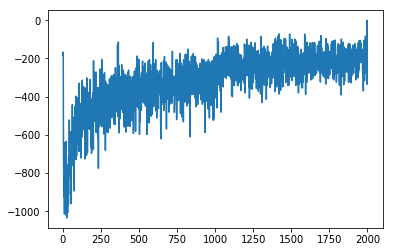

In [150]:
plt.plot(net.costs)

In [108]:
# loading data
letters_raw_data = sp.io.loadmat("hw6_data_dist/letters_data")
letters_data = letters_raw_data['train_x']
letters_labels = letters_raw_data['train_y']
print(letters_labels.shape)
new_letters_labels = []
for label in letters_labels:
    temp = np.zeros(26)
    temp[label[0] - 1] = 1
    new_letters_labels.append(temp)
letters_labels = np.array(new_letters_labels)

letters_test_data = letters_raw_data['test_x']

# pre-processing data
SS = StandardScaler()
letters_data = SS.fit_transform(letters_data)


data_to_shuffle = np.hstack([letters_data, letters_labels])
np.random.shuffle(data_to_shuffle)
letters_data = np.hstack([data_to_shuffle[:,:-26], np.ones((letters_data.shape[0], 1))])
print('combined  ' + str(data_to_shuffle.shape))
print('add bias to x and split off from y ' + str(letters_data.shape))
letters_labels = data_to_shuffle[:,-26:]
print('y one hot' + str(letters_labels.shape))
letters_train_data = letters_data[:int(.8*len(letters_data))]
letters_train_labels = letters_labels[:int(.8*len(letters_labels))]
letters_valid_data = letters_data[int(.8*len(letters_data)):]
letters_valid_labels = letters_labels[int(.8*len(letters_labels)):]

un_one_hot = lambda y: np.array([list(row).index(1) + 1 for row in y])

letters_valid_labels_not_one_hot = un_one_hot(letters_valid_labels)



(124800, 1)


/Users/maialena/anaconda/envs/189hw/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


combined  (124800, 810)
add bias to x and split off from y (124800, 785)
y one hot(124800, 26)


In [109]:
anwar = NeuralNet(letters_train_data, letters_train_labels, numHiddenLayers=800, batchSize=50, numIterations=100000)

In [110]:
p = anwar.predict(letters_valid_data)

halfway predictions


In [111]:
accuracy = accuracy_score(p, letters_valid_labels_not_one_hot)
accuracy

0.039102564102564102